In [1]:
import equinox as eqx
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax
from flowjax.distributions import Normal
from flowjax.flows import masked_autoregressive_flow
from flowjax.train import fit_to_variational_target
from gnpe.losses import AmortizedMaximumLikelihood, ContrastiveLoss
from gnpe.models import (
    LocScaleHierarchicalGuide,
)
from gnpe_experiments.plot_utils import plot_contrastive_aux

from gnpe.numpyro_utils import prior_log_density
from gnpe.train import train
from jax import vmap
from numpyro.infer import Predictive

from gnpe_experiments.metrics import sample_posterior
from gnpe_experiments.plot_utils import pairplot_dictionary
from gnpe_experiments.tasks.sirsde.sirsde import (
    SIRSDE,
    get_hierarchical_sir_model,
    get_processors,
)
n_obs = 50
key = jr.PRNGKey(2024)

In [2]:
model = get_hierarchical_sir_model(n_obs=n_obs)

In [3]:
pred = Predictive(model, num_samples=1)
key, subkey = jr.split(key)
observations = pred(subkey)

# Drop num samples dimension of 1
observations = {k: v.squeeze(0) for k, v in observations.items()}
assert not any(jnp.isnan(arr).any() for arr in observations.values())

In [4]:
key, subkey = jr.split(key)
guide = LocScaleHierarchicalGuide(
    key=subkey, z_dim=model.z_dim, x_dim=model.x_dim, n_obs=model.n_obs,

)

100%|██████████| 3000/3000 [02:23<00:00, 20.97it/s, loss=271]


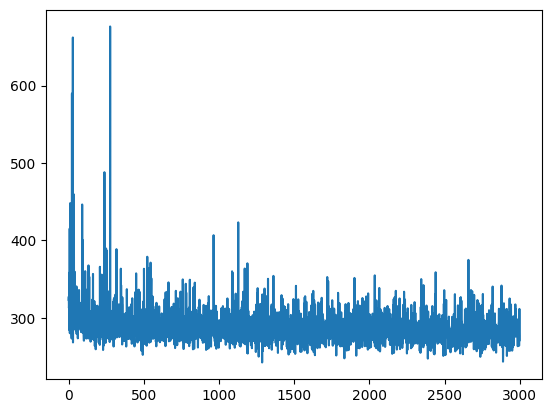

In [5]:
# Pretrain using amortized maximum likelihood
steps=3000

loss = AmortizedMaximumLikelihood(
    model=model,
    obs_name="x",
)

optimizer = optax.apply_if_finite(
    optax.chain(
        optax.clip_by_global_norm(1),
        optax.adam(optax.linear_schedule(1e-2, 5e-4, steps)),
    ),
    max_consecutive_errors=10,
    )

guide_aml, losses = fit_to_variational_target(
    subkey,
    dist=guide,
    loss_fn=loss,
    steps=steps,
    optimizer=optimizer,
    )
plt.plot(jnp.array(losses)[jnp.array(losses)<=1e4])

del guide
# 29.7it/s # 41/s

In [6]:
for k, v in {"prior": model, "posterior": guide_aml}.items():
    predictive = Predictive(v, num_samples=1)
    samps = predictive(key, obs=observations["x"])
    samps = {k: jnp.squeeze(v, 0) for k, v in samps.items()}
    prior_log_prob = prior_log_density(model, data=samps, observed_nodes=["x"])
    print(f"{k}: {prior_log_prob}")

prior: -303.5548095703125
posterior: -311.6821594238281


In [9]:

def plot_results(guide, n: int = 400, obs_id=0):
    prior_and_predictive = Predictive(model, num_samples=n)(key) # TODO key handling
    processors = get_processors()

    posterior_and_predictive = sample_posterior(
        key=jr.PRNGKey(0),
        guide=guide,
        obs=observations["x"],
        n=n,
        model=model,
        )
    
    # Global param plot
    for var_name in ["loc_base", "scale_base"]:
        plot_data = {
            "prior": prior_and_predictive[var_name][:n],
            "posterior": posterior_and_predictive[var_name][:n],
            "observations": observations[var_name],
            }
        
        pairplot_dictionary(
            plot_data,
            equalize_points=False,
            shuffle=False,
            column_names=[f"{var_name}_{z_name}" for z_name in SIRSDE.z_names],
        )

        

    # Global plot of z 
    for var_name, dim, col_names in [
        ("z", model.z_dim, SIRSDE.z_names),
        ("x", model.x_dim, SIRSDE.x_names),
        ]:
        plot_data = {
            "prior": prior_and_predictive[var_name].reshape(-1, dim),
            "posterior": posterior_and_predictive[var_name].reshape(-1, dim)[:n],
            "observations": observations[var_name],
            }
        
        if var_name in processors:
            plot_data = {
                k: vmap(processors[var_name].inverse)(v) for k, v in plot_data.items()
                }

        pairplot_dictionary(
            plot_data,
            equalize_points=False,
            shuffle=False,
            column_names=col_names,
        )
    plt.show()

    # Plot posterior for a specific observation
    for var_name, col_names in [
        ("z", SIRSDE.z_names), ("x", SIRSDE.x_names),
        ]:

        plot_data = {
            "prior": prior_and_predictive[var_name][:, obs_id, :],
            "posterior": posterior_and_predictive[var_name][:, obs_id, :],
            "observations": observations[var_name][obs_id, :],
            }
            
        if var_name in processors:

            plot_data = {
                k: jnp.vectorize(
                    processors[var_name].inverse, signature="(a)->(b)",
                    )(v) for k, v in plot_data.items()
                }  # TODO why are we doing this twice?

        pairplot_dictionary(
            plot_data,
            column_names=col_names,
        )
    plt.show()


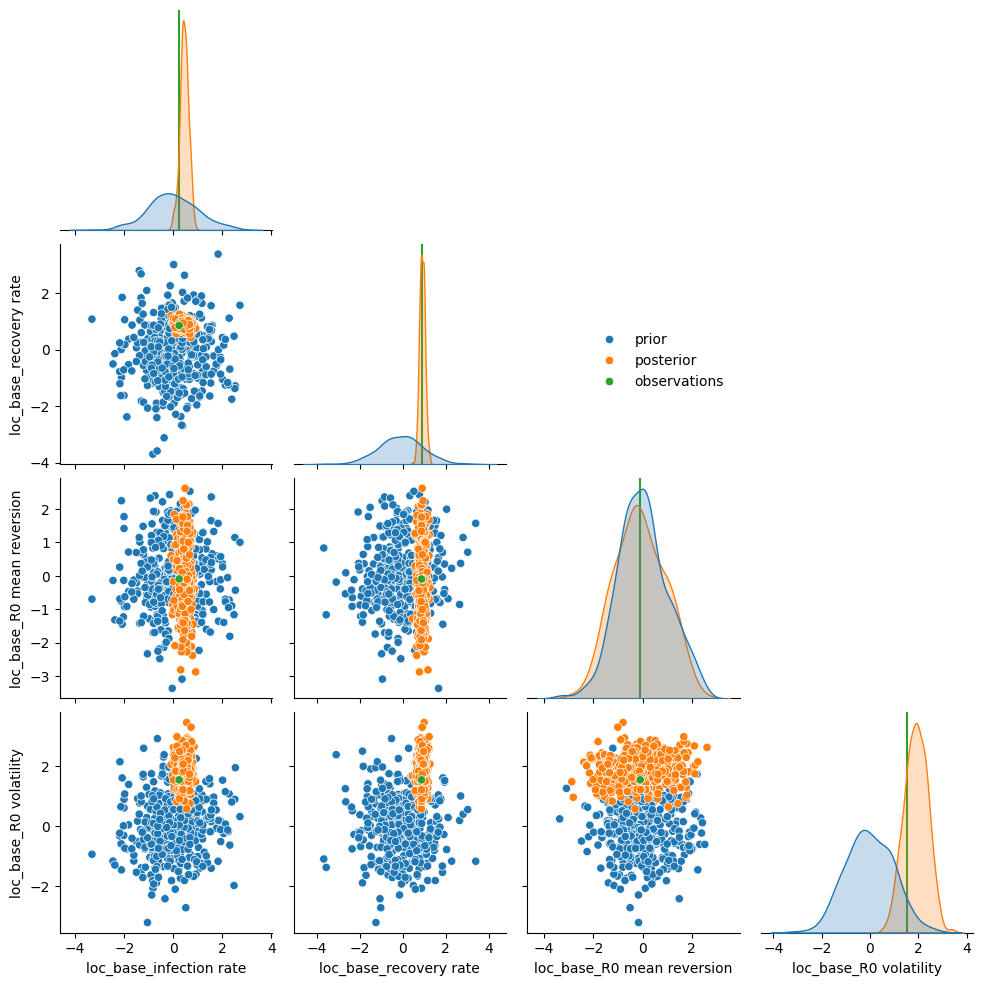

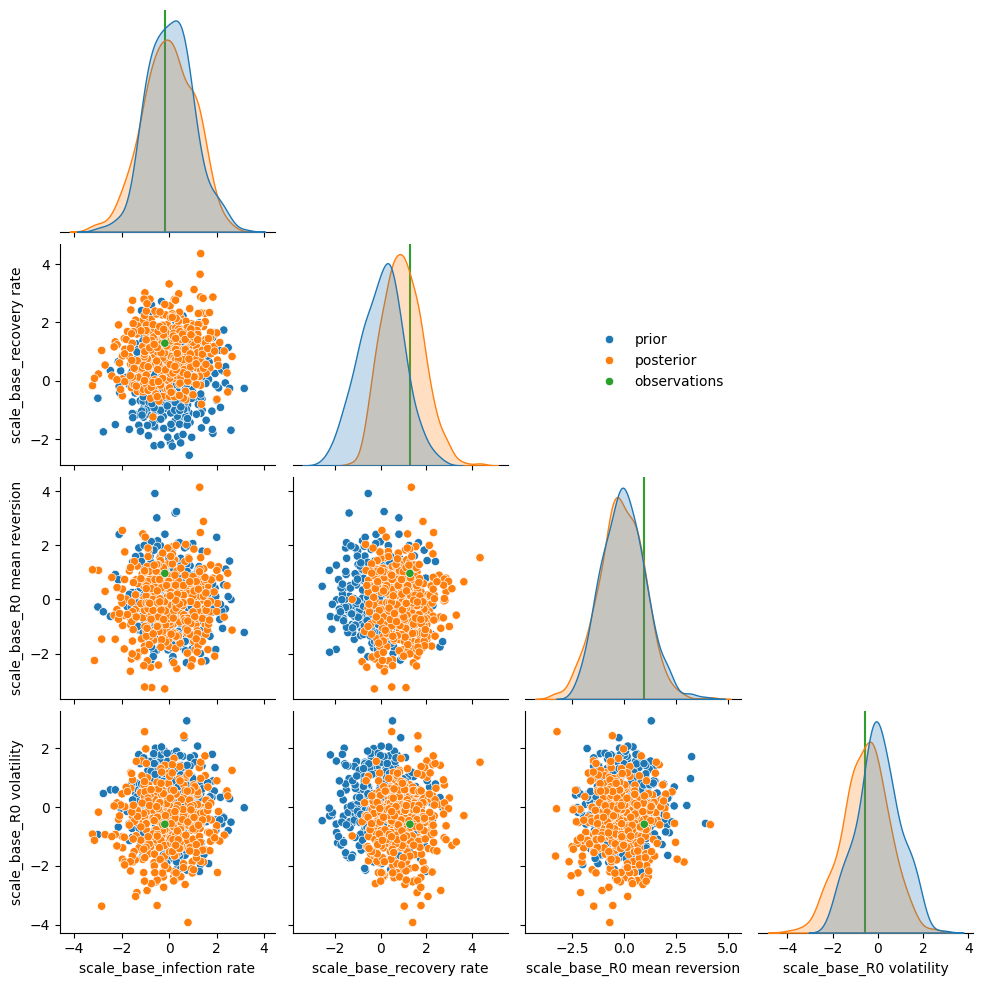

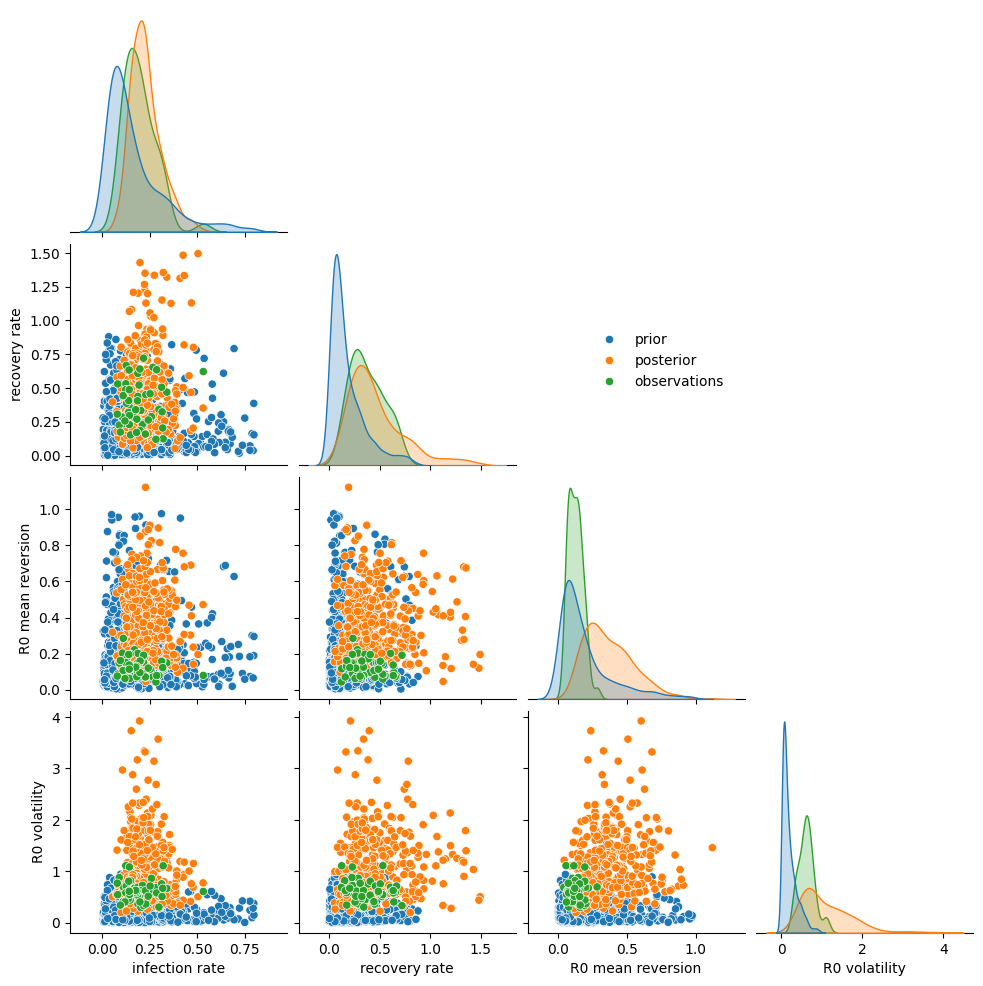

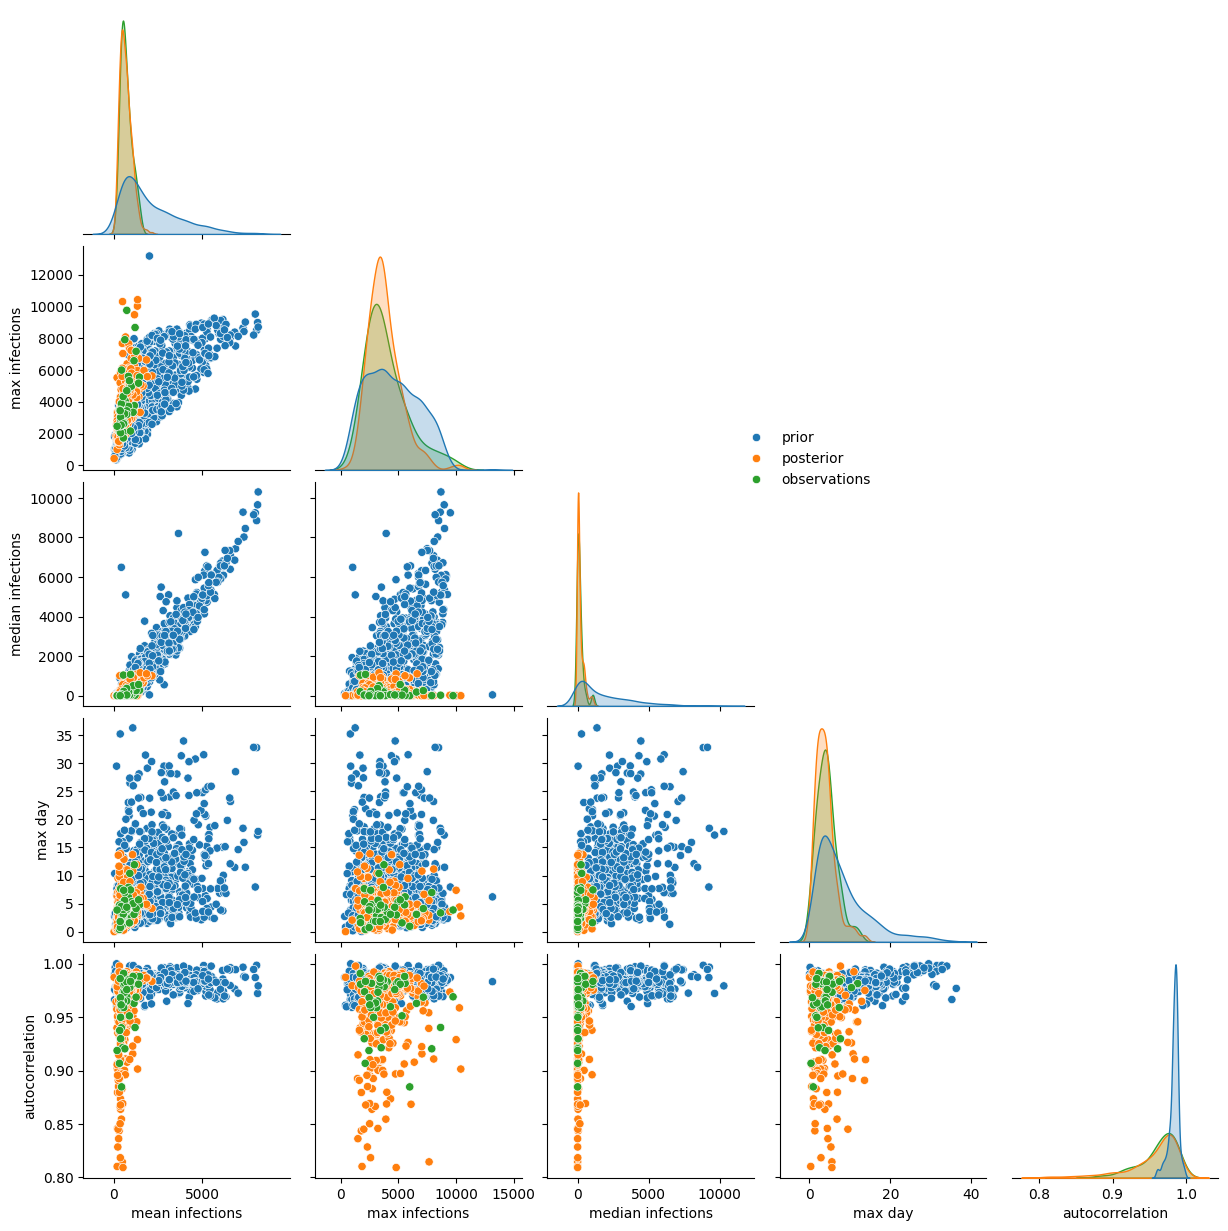

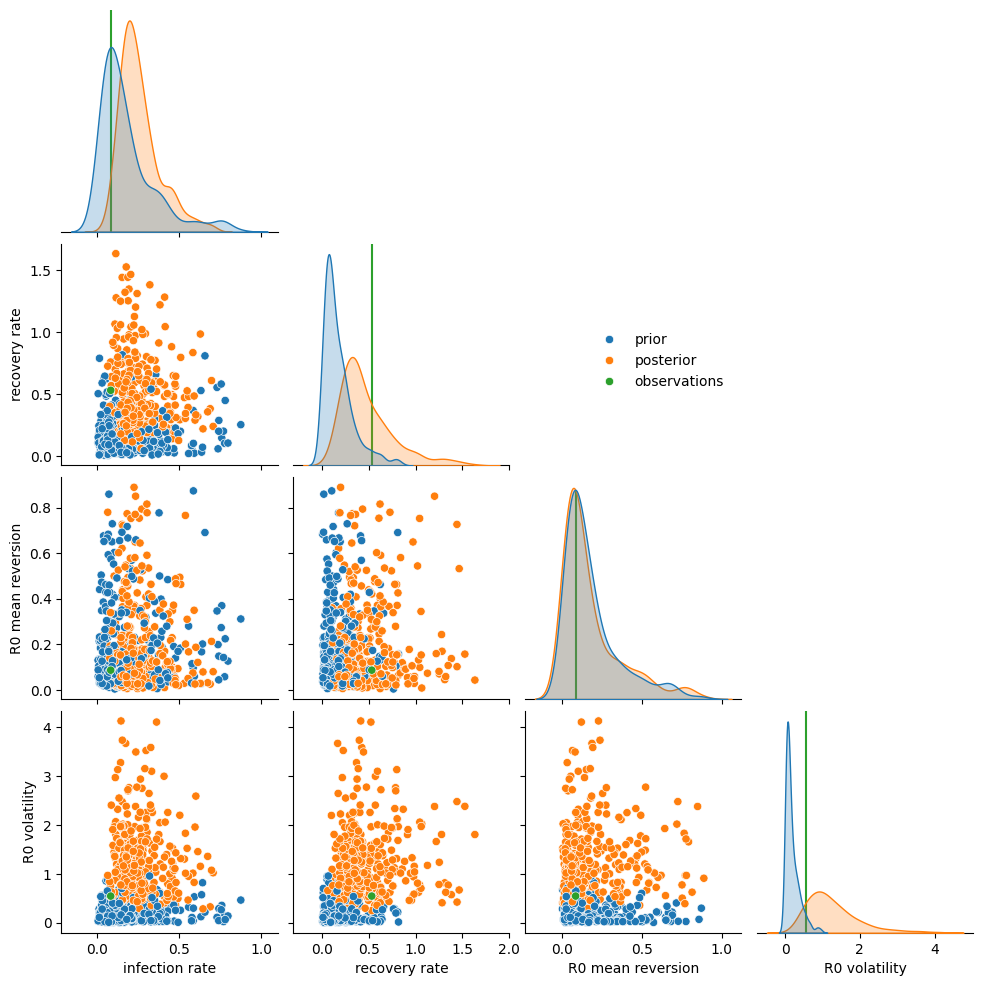

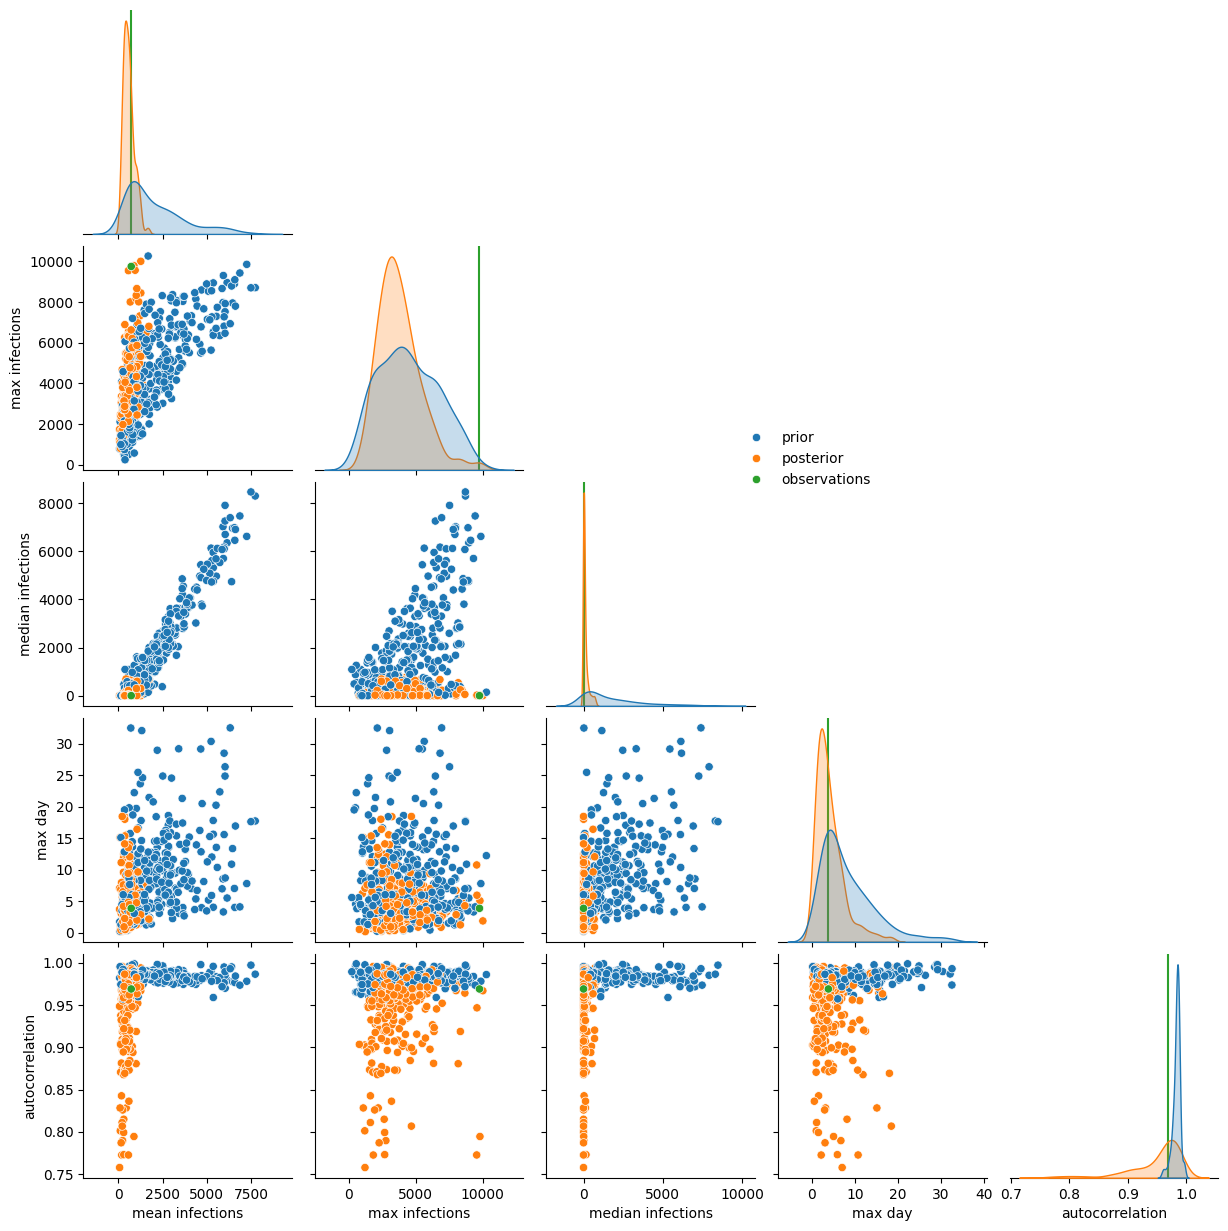

In [10]:
plot_results(guide_aml)

In [11]:
# Fine tune with contrastive loss
loss = ContrastiveLoss(
    model=model,
    obs=observations["x"],
    obs_name="x",
    n_contrastive=20,
    aux=True,
    stop_grad_for_contrastive_sampling=False,
)

In [12]:
key, subkey = jr.split(key)

optimizer = optax.apply_if_finite(
    optax.chain(
        optax.clip_by_global_norm(1),
        optax.adam(1e-4),
    ),
    max_consecutive_errors=500,
    )

guide_contrastive, losses, aux = train(
    subkey,
    dist=guide_aml,
    loss_fn=loss,
    steps=1000,
    optimizer=optimizer,
    has_aux=True,
    convergence_window_size=200,
    )


 63%|██████▎   | 631/1000 [04:48<02:48,  2.19it/s, loss=605] 

Convergence criteria reached.


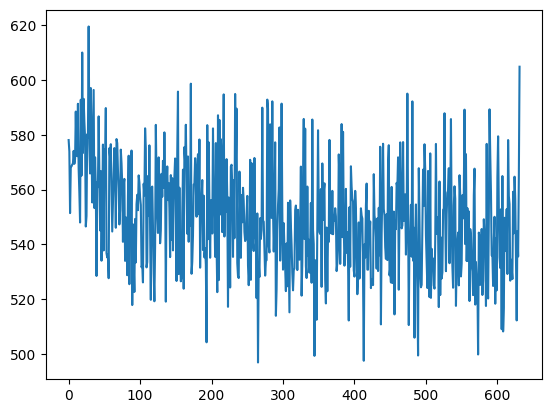

In [13]:
plt.plot(jnp.asarray(losses).ravel())

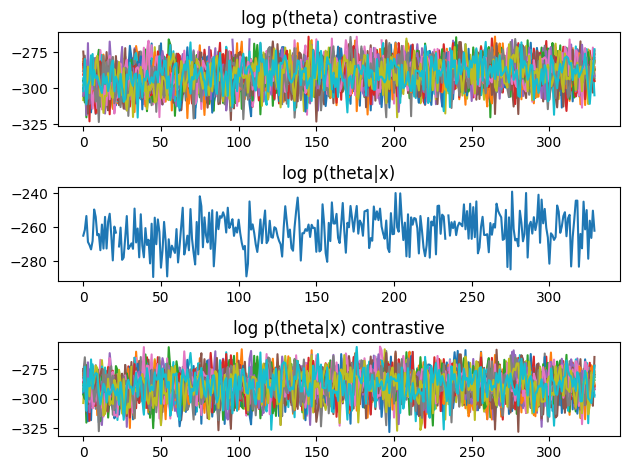

In [ ]:
plot_contrastive_aux(aux)

In [ ]:
from gnpe_experiments.metrics import posterior_probability_true
from functools import partial

print(
    prior_log_density(
        partial(model, obs=observations["x"]),
        data={k: v for k, v in observations.items() if k!="x"},
        observed_nodes=["x"],
    ),
)


print(
    posterior_probability_true(
        guide_aml,
        true_latents={k: v for k, v in observations.items() if k!="x"},
        obs=observations["x"],
    )[0],
)

print(
    posterior_probability_true(
        guide_contrastive,
        true_latents={k: v for k, v in observations.items() if k!="x"},
        obs=observations["x"],
    )[0],
)

-301.48584
-289.6446
-283.34958


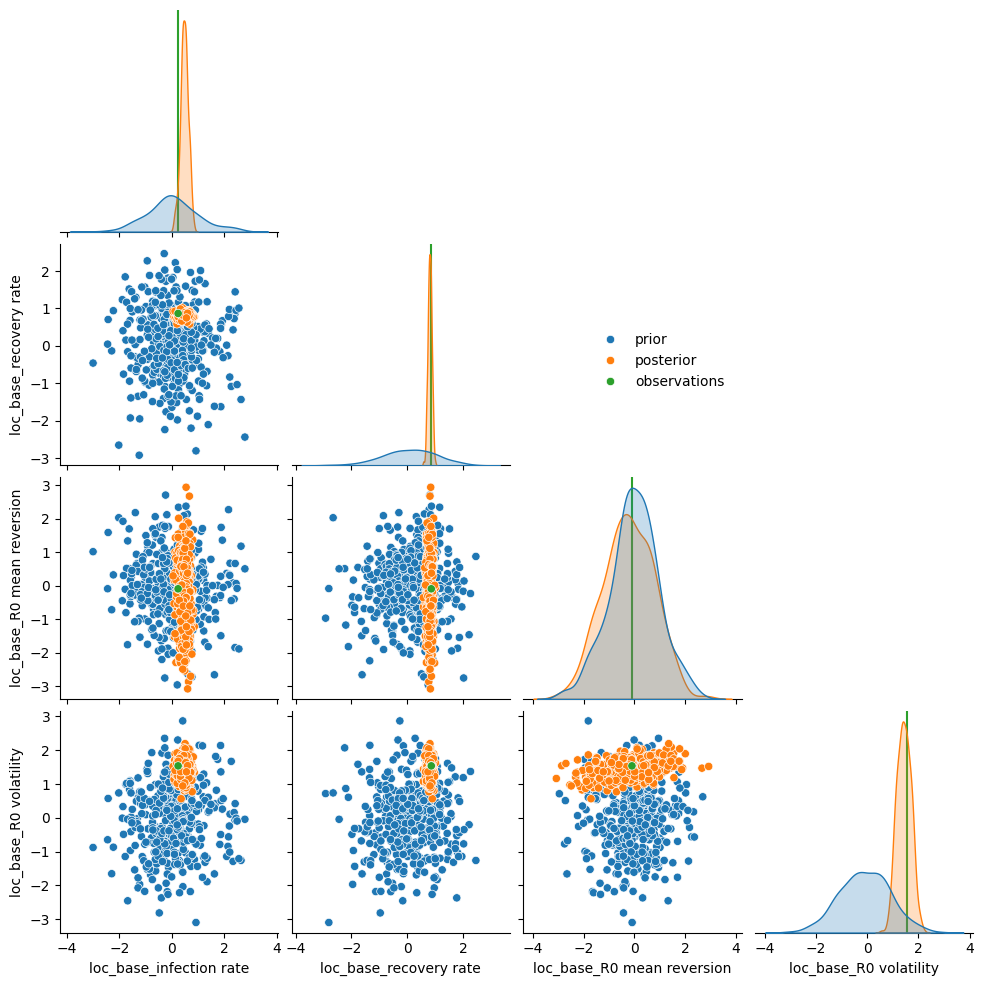

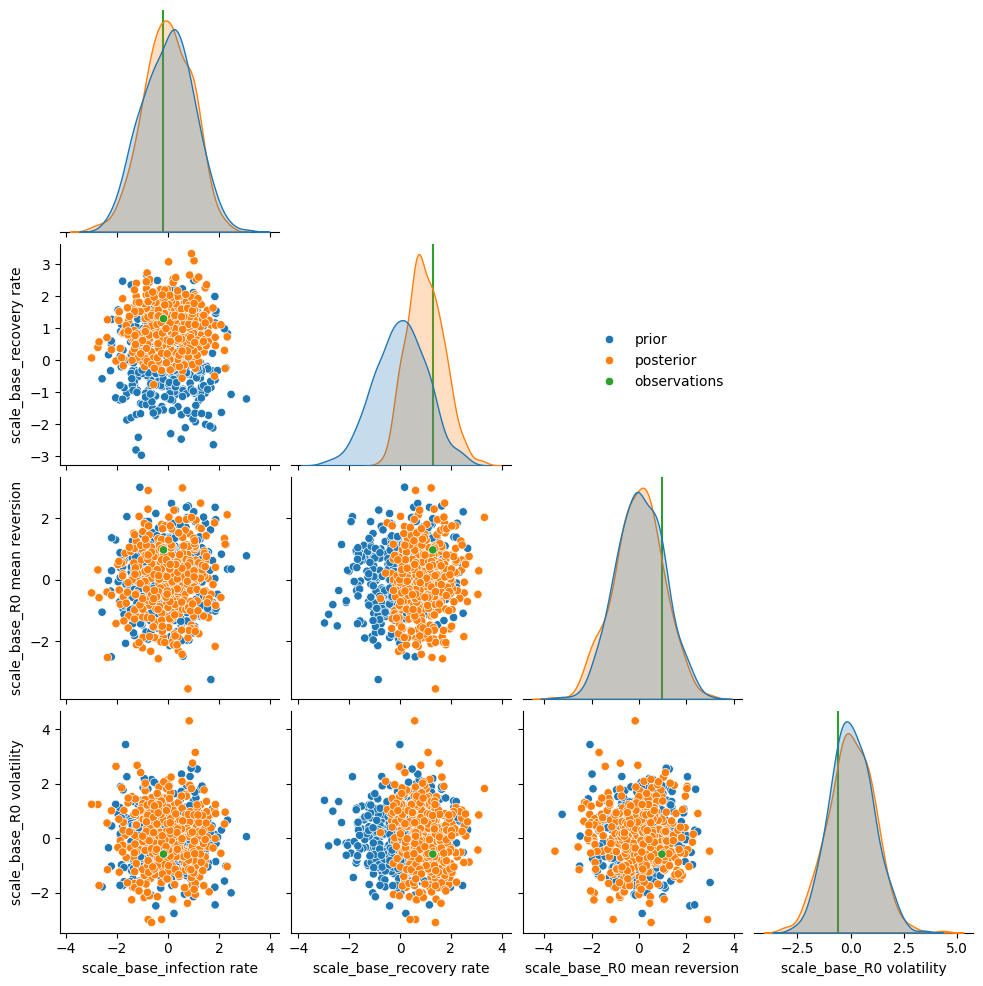

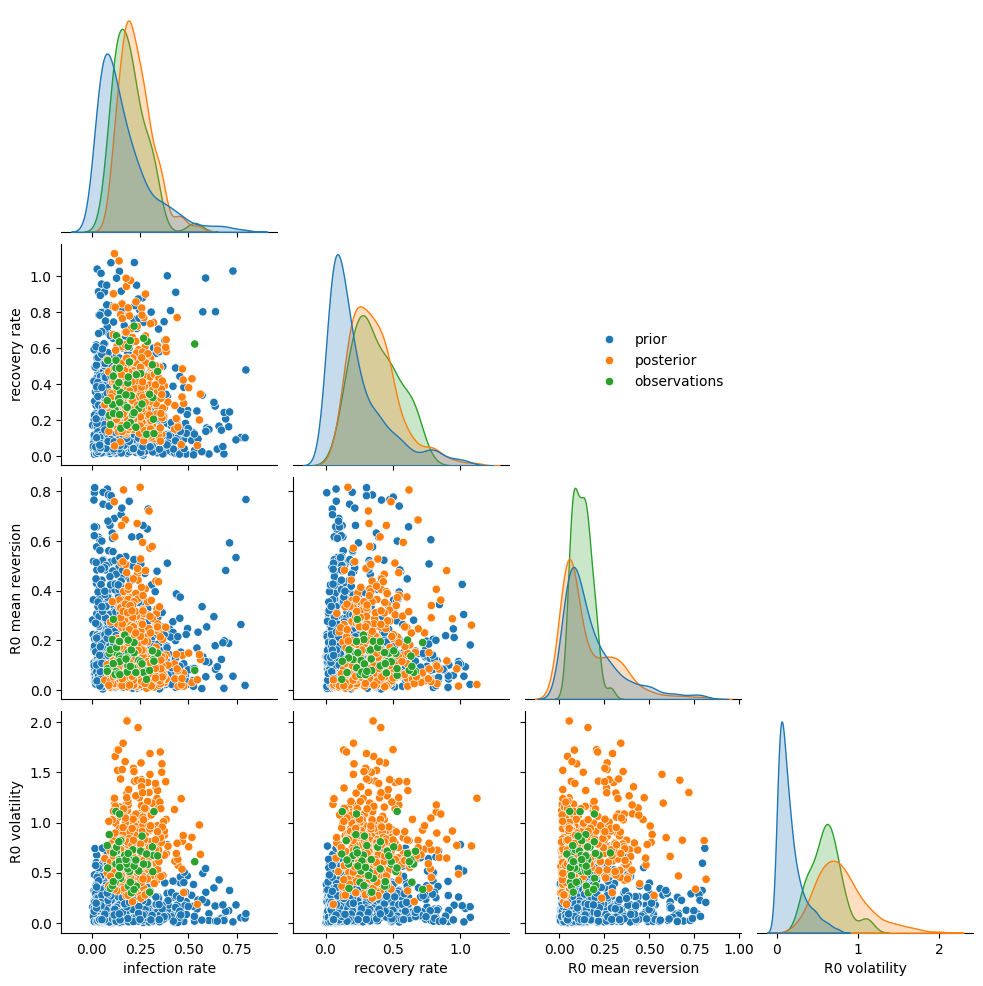

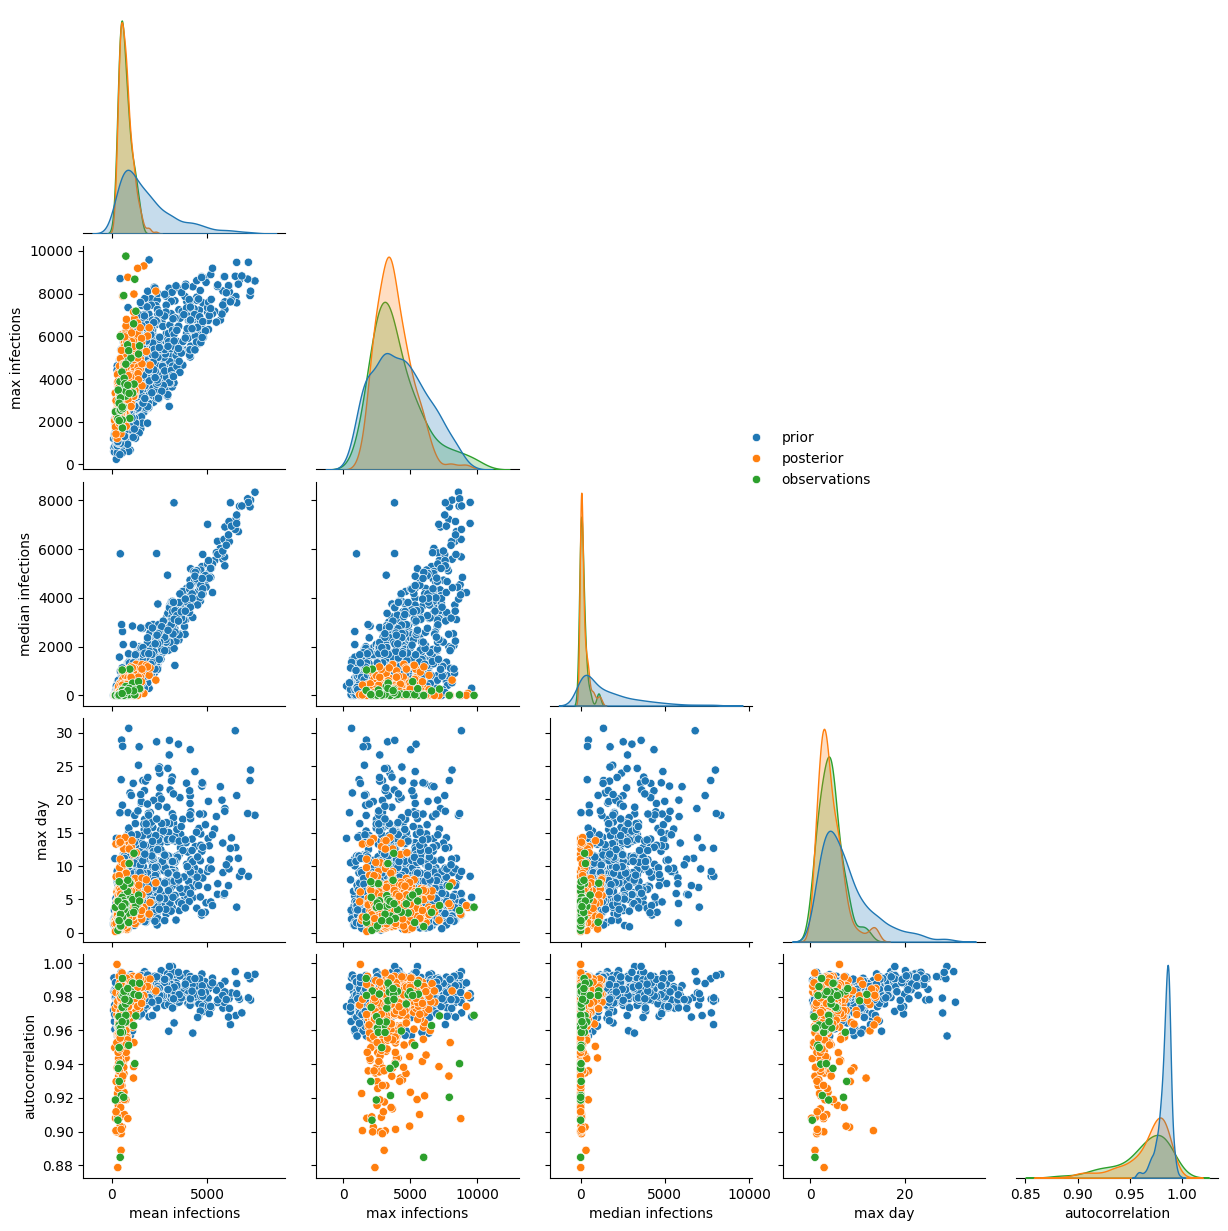

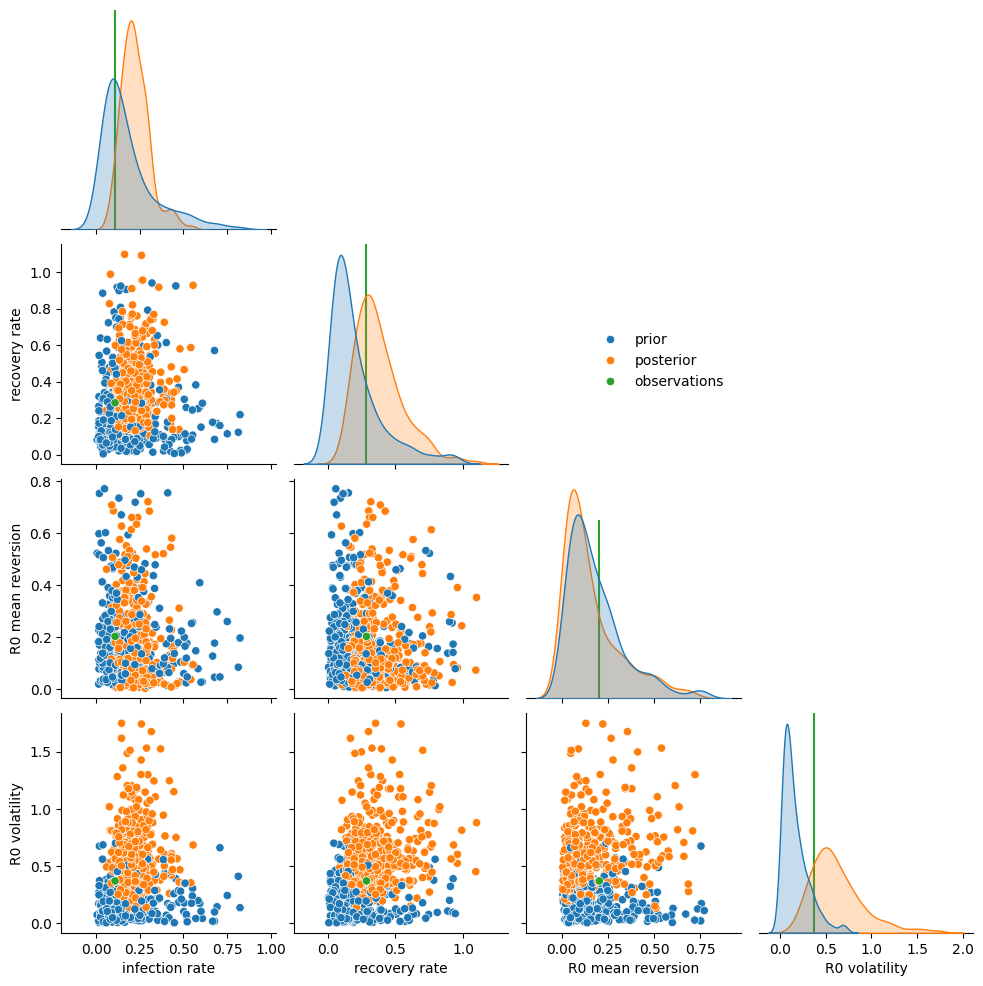

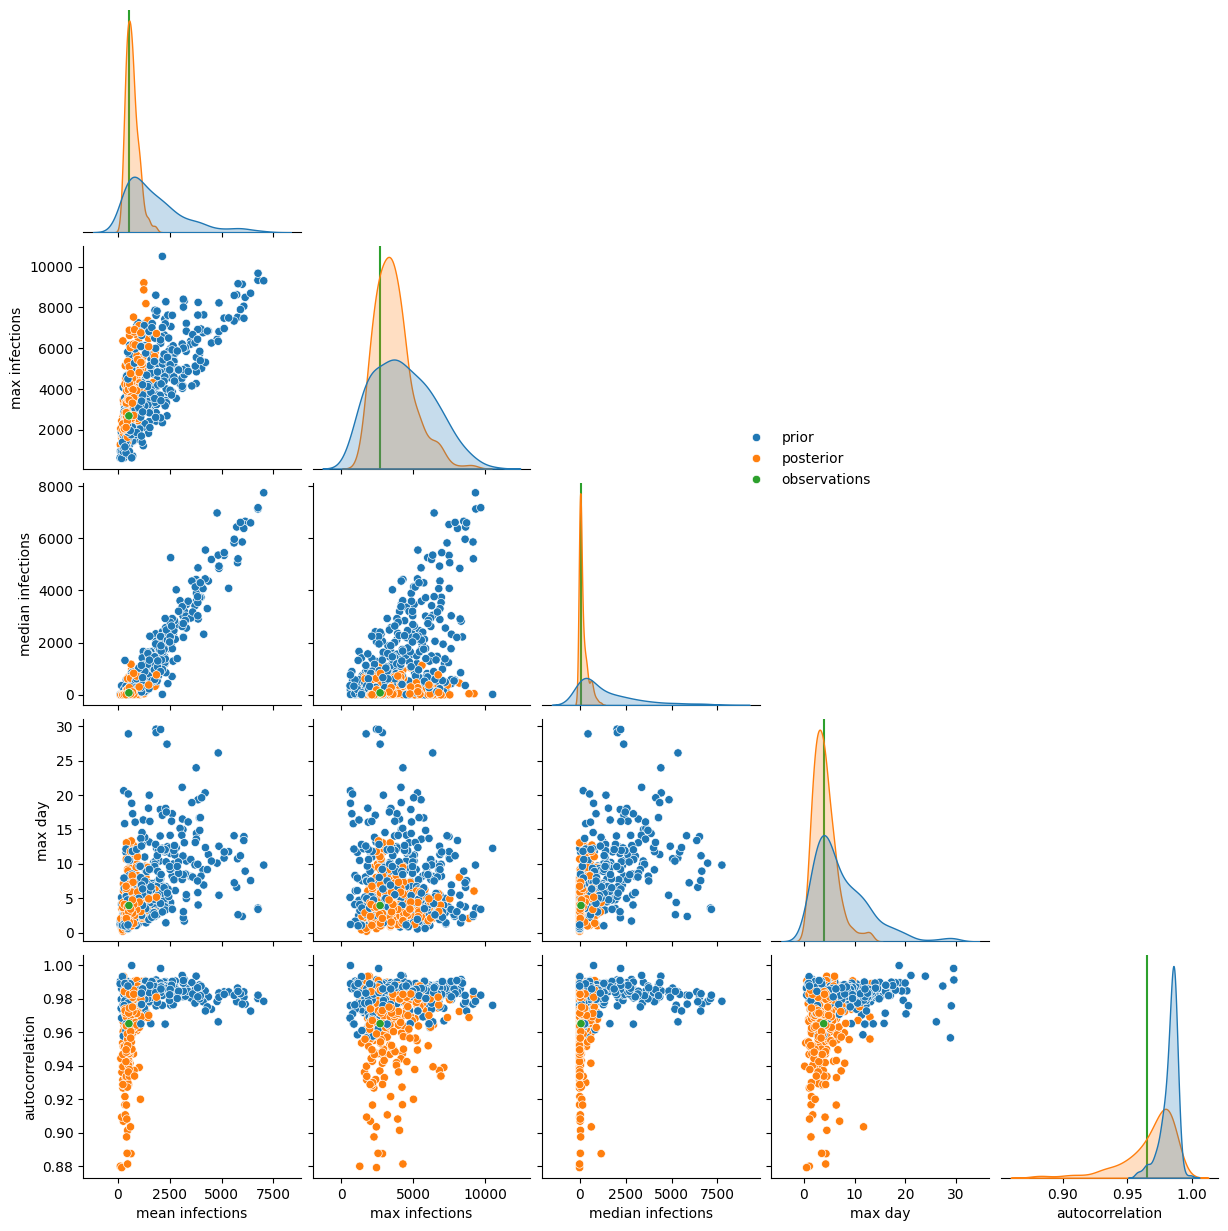

In [ ]:
plot_results(guide_contrastive, obs_id=1)

In [ ]:
# # Gradient comparison:
# from functools import partial
# import jax
# from jax.flatten_util import ravel_pytree

# n_contrastive = 30
# n=10

# loss_stop_grad, loss_no_stop_grad = (
#     ContrastiveLoss(
#         model=model,
#         obs=observations["x"],
#         obs_name="x",
#         n_contrastive=n_contrastive,
#         stop_grad_for_contrastive_sampling=stop_grad,
#     ) for stop_grad in (True, False)
# )

# losses = {
#     "stop_grad": loss_stop_grad,
#     "no_stop_grad": loss_no_stop_grad,
# }

# grads = {}

# for k, loss in losses.items():

#     params, static = eqx.partition(guide_contrastive, eqx.is_inexact_array)

#     @eqx.filter_jit
#     def grad_single(key, params, static, loss):
#         return eqx.filter_jit(eqx.filter_grad(loss))(params, static, key)
    
    
#     grad_single = partial(grad_single, params=params, static=static, loss=loss)

#     keys = jr.split(jr.PRNGKey(0), n)
#     grads[k] = jax.lax.map(grad_single, keys)


# stop_grad_grads = eqx.filter_vmap(ravel_pytree)(grads["stop_grad"])[0]
# no_stop_grad_grads = eqx.filter_vmap(ravel_pytree)(grads["no_stop_grad"])[0]

# plt.scatter(
#     stop_grad_grads.mean(axis=0),
#     no_stop_grad_grads.mean(axis=0),
#     s=3,
# )

# plt.title(f"Mean gradient for each parameter over {n} samples (each point is a parameter)")
# plt.xlabel(r"$\phi$ not in contrastive sampling")
# plt.ylabel(r"$\phi$ in contrastive sampling")
# plt.plot([-5, 5], [-5, 5], color="tab:orange")
# plt.show()

# plt.scatter(
#     stop_grad_grads.var(axis=0),
#     no_stop_grad_grads.var(axis=0),
#     s=1,
# )
# plt.plot([0, 200], [0, 200], color="tab:orange")
# plt.title(f"Variance of gradient for each parameter over {n} samples (each point is a parameter)")
# plt.xlabel(r"$\phi$ not in contrastive sampling")
# plt.ylabel(r"$\phi$ in contrastive sampling")
# plt.xlim(0, 50)
# plt.ylim(0, 50)
# plt.show()
